#Requirements

In [ ]:
!pip install tensorflow==2.12.0
!pip install scikit-image
!pip install scikit-learn
!pip install opencv-python-headless
!pip install numpy
!pip install matplotlib
!pip install glob2
!pip install pickle5
!pip install google-colab

#Imports

In [58]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import os
import pickle
import tensorflow
from tensorflow import keras
from keras import layers,models


from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2ycbcr
from skimage.transform import resize

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, roc_auc_score


import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Convolutional Neural Network (CNN)

##Data preparation

###Extract images from the videos



In [ ]:
#For potential data augmentation
"""def rotation(image, seed=777,rota=0):
    random.seed(seed)
    angle= rota
    r_img = rotate(image, angle, mode='reflect', reshape=False, order=0)
    return r_img

def v_transl(image, seed=777,decalage=0):
    random.seed(seed)
    n_pixels = decalage
    vtranslated_img = np.roll(image, n_pixels, axis=0)
    return vtranslated_img

def h_transl(image, seed=777,decalage=0):
    random.seed(seed)
    n_pixels = decalage
    htranslated_img = np.roll(image, n_pixels, axis=1)
    return htranslated_img"""

In [4]:
label2int = {
    'dislike' : 0,
    'like' : 1,
    'ok' : 2,
    'point' : 3,
    'slide_1' : 4,
    'slide_2' : 5,
    'take_a_picture' : 6
}

X_set = []
Y_set = []
for path_director in glob.glob('/content/drive/MyDrive/demo_room/*'):

  label1 = path_director.split('/')[-1]
  print(label1)
  for image_path in glob.glob(path_director+'/*'):
      cap=cv2.VideoCapture(image_path)

      label = image_path.split('/')[-1].split('_')[0]
      if label=='slide' or label=='take'  :
        label=label+'_'+image_path.split('/')[-1].split('_')[1]
        if label=='take_a':
          label=label+'_'+image_path.split('/')[-1].split('_')[2]
      nb=0
      while cap.isOpened():

        imageId=cap.get(1)
        ret,image=cap.read()
        if ret !=True:
          break

        if imageId != 0 and imageId % 4 == 0:
            nb=nb+1
            image=cv2.cvtColor(image , cv2.COLOR_BGR2RGB)

            if image.ndim==3:
              image = cv2.GaussianBlur(image, (5,5) , 100)
              red , green , blue = image[:,:,0] ,image[:,:,1] , image[:,:,2]

              #get the HSV version
              image_hsv = rgb2hsv(image)
              hue = image_hsv[:,:,0]
              sat = image_hsv[:,:,1]

              #get the ycbcr version
              image_ycbcr = rgb2ycbcr(image)
              y = image_ycbcr[:,:,0]
              cb = image_ycbcr[:,:,1]
              cr = image_ycbcr[:,:,2]

              """#HSV+RBGA mask for hand extraction
              mask = (hue>=0) & (hue<=0.13888) & (sat>=0.23) & (sat<=0.68) & (red>95) & (green > 40) & (blue > 20) & (red > green) & (red > blue) & (np.abs(red - green) > 15)
              """
              #YCBCR+RGBA mask for hand extraction
              mask = (red > 95) & (green > 40) & (blue > 20) & (red > green) & (red > blue) & (np.abs(red - green) > 15) & (cr > 135) & (cb > 85) & (y > 80) & (cr <= (1.5862*cb)+20) & (cr >= (0.3448*cb)+76.2069) & (cr >= (-4.5652*cb)+234.5652) & (cr <= (-1.15 * cb)+301.75) & (cr <= (-2.2857*cb)+432.85)

              mask = mask.astype(np.uint8)
              mask[mask == 1] = 255
              np.sum(mask == 255)


              kernel = np.ones((5,5), np.uint8)
              mask1 = cv2.erode(mask , kernel , iterations=2)
              kernel = np.ones((5,5), np.uint8)
              image = cv2.dilate(mask1 , kernel , iterations=4)
              image=resize(image,(128,128))

              X_set.append(image)
              Y_set.append(label2int[label])
print(len(X_set))
print(len(Y_set))


subject_5
subject_4
subject_3
subject_1
subject_2
6029
6029


###Save the obtained data

In [7]:
X=np.array(X_set).reshape(-1,128,128,1)
Y=np.array(Y_set)

pickle_out=open("X_data_CNN.pickle","wb")
pickle.dump(X,pickle_out)
pickle_out.close()

pickle_out=open("Y_data_CNN.pickle","wb")
pickle.dump(Y,pickle_out)
pickle_out.close()

In [20]:
pickle_in1=open("X_data_CNN.pickle","rb")
X_cnn=pickle.load(pickle_in1)

pickle_in2=open("Y_data_CNN.pickle","rb")
Y_cnn=pickle.load(pickle_in2)

###Split into train and test sets


In [74]:
X_trainn, X_testn, Y_train, Y_test = train_test_split(X_cnn , Y_cnn , test_size=0.15, shuffle=True, random_state=123, stratify=Y_cnn )

#Normalize the image pixels to the range [0,1]
X_train=X_trainn/255.0
X_test=X_testn/255.0

print(X_trainn.shape)
print(Y_train.shape)
print(X_testn.shape)
print(Y_test.shape)

(5124, 128, 128, 1)
(5124,)
(905, 128, 128, 1)
(905,)


##Model configuration

In [22]:
cnn=models.Sequential([

    layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu",input_shape=(X_train.shape[1:])),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.05),

    layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.07),

    layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.15),

    #dense

    layers.Flatten(name='flatten'),
    layers.Dense(150,activation="relu",name='dense1'),
    layers.Dropout(0.15),
    layers.Dense(7,activation="softmax")
    ])

cnn.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

##Model Training

Epoch 1/15
154/154 [==============================] - 269s 2s/step - loss: 1.9248 - accuracy: 0.1739 - val_loss: 1.8984 - val_accuracy: 0.2378
Epoch 2/15
154/154 [==============================] - 253s 2s/step - loss: 1.3277 - accuracy: 0.4860 - val_loss: 0.9816 - val_accuracy: 0.6218
Epoch 3/15
154/154 [==============================] - 243s 2s/step - loss: 0.8590 - accuracy: 0.6825 - val_loss: 0.7667 - val_accuracy: 0.7310
Epoch 4/15
154/154 [==============================] - 246s 2s/step - loss: 0.6671 - accuracy: 0.7597 - val_loss: 0.6051 - val_accuracy: 0.7914
Epoch 5/15
154/154 [==============================] - 241s 2s/step - loss: 0.5564 - accuracy: 0.8057 - val_loss: 0.5527 - val_accuracy: 0.8207
Epoch 6/15
154/154 [==============================] - 250s 2s/step - loss: 0.4844 - accuracy: 0.8287 - val_loss: 0.5546 - val_accuracy: 0.8148
Epoch 7/15
154/154 [==============================] - 244s 2s/step - loss: 0.4193 - accuracy: 0.8508 - val_loss: 0.4723 - val_accuracy: 0.8441

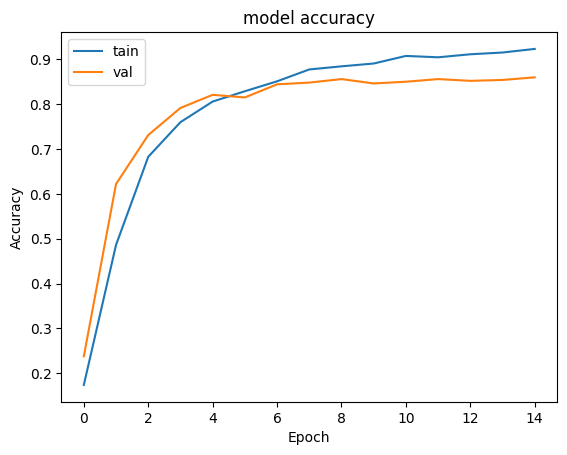

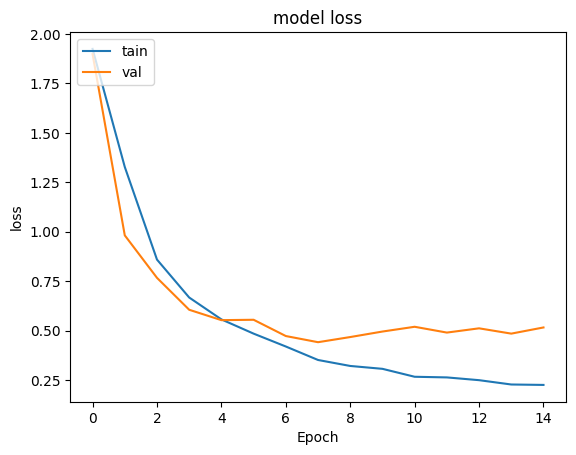

In [23]:
history=cnn.fit(X_train,Y_train,batch_size=30,validation_split=0.1,epochs=15)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['tain','val'],loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['tain','val'],loc='upper left')
plt.show()

In [24]:
cnn.save("CNNmodel.h5")
c=models.load_model('CNNmodel.h5')

##Model testing and evaluation

In [25]:
cnn.evaluate(X_test,Y_test)

29/29 [==============================] - 10s 332ms/step - loss: 0.5267 - accuracy: 0.8552


[0.5266959071159363, 0.8552486300468445]

In [75]:
y_prediction=cnn.predict(X_test)
y_prediction = [np.argmax(element)for element in y_prediction ]

print(classification_report(Y_test,y_prediction))
print(confusion_matrix(Y_test , y_prediction))

roc = roc_auc_score(Y_test, cnn.predict(X_test), multi_class ='ovr')
kappa = cohen_kappa_score(Y_test, cnn.predict(X_test).argmax(axis=1))

print("Roc score", roc)
print("Kappa score", kappa)

29/29 [==============================] - 17s 590ms/step
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       148
           1       0.84      0.88      0.86       138
           2       0.83      0.87      0.85       143
           3       0.87      0.83      0.85       135
           4       0.70      0.71      0.70        89
           5       0.87      0.85      0.86        86
           6       0.94      0.90      0.92       166

    accuracy                           0.86       905
   macro avg       0.85      0.85      0.85       905
weighted avg       0.86      0.86      0.86       905

[[129   1   3   4   7   1   3]
 [  1 122   6   4   3   1   1]
 [  7   5 125   2   2   1   1]
 [  3   6  11 112   1   2   0]
 [  1   8   6   6  63   2   3]
 [  4   1   0   0   7  73   1]
 [  1   3   0   1   7   4 150]]
29/29 [==============================] - 9s 314ms/step
Roc score 0.9811695281499756
Kappa score 0.8298171347036388


#Long Short Term Memory (LSTM)

##Data preparation

###Extract image sequences from the videos



In [ ]:
#For potential data augmentation
"""def rotation(image, seed=777,rota=0):
    random.seed(seed)
    angle= rota
    r_img = rotate(image, angle, mode='reflect', reshape=False, order=0)
    return r_img

def v_transl(image, seed=777,decalage=0):
    random.seed(seed)
    n_pixels = decalage
    vtranslated_img = np.roll(image, n_pixels, axis=0)
    return vtranslated_img

def h_transl(image, seed=777,decalage=0):
    random.seed(seed)
    n_pixels = decalage
    htranslated_img = np.roll(image, n_pixels, axis=1)
    return htranslated_img"""

In [27]:
label2int = {
    'dislike' : 0,
    'like' : 1,
    'ok' : 2,
    'point' : 3,
    'slide_1' : 4,
    'slide_2' : 5,
    'take_a_picture' : 6
}
Y_set = []
X_set = []
i=0

for path_director in glob.glob('/content/drive/MyDrive/demo_room/*'):

  label1 = path_director.split('/')[-1]
  print(label1)
  for image_path in glob.glob(path_director+'/*'):
    tempx=[]
    tempy=[]
    cap=cv2.VideoCapture(image_path)
    label = image_path.split('/')[-1].split('_')[0]
    if label=='slide' or label=='take'  :
      label=label+'_'+image_path.split('/')[-1].split('_')[1]
      if label=='take_a':
        label=label+'_'+image_path.split('/')[-1].split('_')[2]
    nb=0
    while cap.isOpened():

      imageId=cap.get(1)
      ret,image=cap.read()
      if ret !=True:
        break

      if  imageId != 0 :
        if imageId % 4 == 0:
          nb=nb+1
          image=cv2.cvtColor(image , cv2.COLOR_BGR2RGB)

          if image.ndim==3:
            #print(image_path)
            image = cv2.GaussianBlur(image, (5,5) , 100)
            red , green , blue = image[:,:,0] ,image[:,:,1] , image[:,:,2]


            image_hsv = rgb2hsv(image)
            hue = image_hsv[:,:,0]
            sat = image_hsv[:,:,1]


            image_ycbcr = rgb2ycbcr(image)
            y = image_ycbcr[:,:,0]
            cb = image_ycbcr[:,:,1]
            cr = image_ycbcr[:,:,2]


            mask = (red > 95) & (green > 40) & (blue > 20) & (red > green) & (red > blue) & (np.abs(red - green) > 15) & (cr > 135) & (cb > 85) & (y > 80) & (cr <= (1.5862*cb)+20) & (cr >= (0.3448*cb)+76.2069) & (cr >= (-4.5652*cb)+234.5652) & (cr <= (-1.15 * cb)+301.75) & (cr <= (-2.2857*cb)+432.85)
            mask = mask.astype(np.uint8)
            mask[mask == 1] = 255
            np.sum(mask == 255)


            kernel = np.ones((5,5), np.uint8)
            mask1 = cv2.erode(mask , kernel , iterations=2)

            kernel = np.ones((5,5), np.uint8)
            image = cv2.dilate(mask1 , kernel , iterations=4)
            #image=cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
            image=resize(image,(128,128))

            tempx.append(image)
            tempy.append(label2int[label])

    X_set.append(tempx)
    Y_set.append(tempy)
    i=i+1
print(i)

subject_5
subject_4
subject_3
subject_1
subject_2
705


###Data reshape and normalization

In [28]:
X_set_array=[]
Y_set_array=[]

for fich in X_set:
  X=np.array(fich).reshape(-1,128,128,1)
  #normalization to the range [0,1]
  X=X/255
  X_set_array.append(X)

for fich in Y_set:
  Y=np.array(fich)
  Y_set_array.append(Y)

print(X_set_array[1].shape)
print(Y_set_array[1].shape)

(11, 128, 128, 1)
(11,)


### Load the CNN dense1 layer weights

In [30]:
c=models.load_model('CNNmodel.h5')

#Get the cnn dense1 layer weights which will be used for feature extraction in the LSTM model
modelfeatures= models.Model(
    inputs=c.input,
    outputs=c.get_layer('dense1').output
)

### Feature extraction for each image

In [34]:
trainfeaturesblock=[]
for X in X_set_array:
  trainf=modelfeatures.predict(X)
  trainfeaturesblock.append(trainf)

print(trainfeaturesblock[0].shape,trainfeaturesblock[1].shape,trainfeaturesblock[2].shape)
print(len(trainfeaturesblock))

1/1 [==============================] - 0s 213ms/step
(10, 150) (11, 150) (12, 150)
705


### Put the images in sequences of 6

In [35]:
X_data=[]
for X in trainfeaturesblock:
  li=[]
  i=0
  for ph in X:
    i=i+1
    li.append(ph)
    if i==6:
      X_data.append(li)
      i=0
      li=[]

print(len(X_data))

721


6

###Reshape data


In [37]:
Y_data1=[]
for Y in Y_set_array:
  li=[]
  i=0
  for classe in Y:
    i=i+1
    li.append(classe)
    if i==6:
      Y_data1.append(li)
      i=0
      li=[]

print(len(Y_data1))
print(len(Y_data1[0]))

721
6


In [38]:
Y_data=[]
for Y in Y_data1:
  Y_data.append(Y[0])
len(Y_data)

721

In [39]:
X_dataset=np.array(X_data).reshape(-1,6,150)
Y_dataset=np.array(Y_data)

print(X_dataset.shape)
print(Y_dataset.shape)

(721, 6, 150)
(721,)


###Save the obtained data

In [42]:
pickle_out=open("X_data_LSTM.pickle","wb")
pickle.dump(X_dataset,pickle_out)
pickle_out.close()

pickle_out=open("Y_data_LSTM.pickle","wb")
pickle.dump(Y_dataset,pickle_out)
pickle_out.close()

In [43]:
pickle_in1=open("X_data_LSTM.pickle","rb")
X_dataset=pickle.load(pickle_in1)

pickle_in2=open("Y_data_LSTM.pickle","rb")
Y_dataset=pickle.load(pickle_in2)

###Split into train and test sets


In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X_dataset , Y_dataset , test_size=0.15, random_state=123,stratify=Y_dataset)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(612, 6, 150)
(612,)
(109, 6, 150)
(109,)


##Model configuration

In [51]:
lstm=models.Sequential([

layers.LSTM(128,input_shape=(X_train.shape[1:]),activation='relu',return_sequences=True),
layers.Dropout(0.2),

layers.LSTM(128,activation='relu'),
layers.Dropout(0.2),

layers.Dense(32,activation='relu'),
layers.Dropout(0.2),

layers.Dense(7,activation='softmax'),

])

opt= tensorflow.keras.optimizers.Adam(learning_rate=1e-4)

lstm.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

##Model training

Epoch 1/30
18/18 [==============================] - 5s 70ms/step - loss: 1.9919 - accuracy: 0.1942 - val_loss: 1.8261 - val_accuracy: 0.2826
Epoch 2/30
18/18 [==============================] - 1s 54ms/step - loss: 1.7181 - accuracy: 0.3462 - val_loss: 1.6890 - val_accuracy: 0.4239
Epoch 3/30
18/18 [==============================] - 1s 54ms/step - loss: 1.5622 - accuracy: 0.4442 - val_loss: 1.5517 - val_accuracy: 0.5109
Epoch 4/30
18/18 [==============================] - 1s 59ms/step - loss: 1.4024 - accuracy: 0.5115 - val_loss: 1.3902 - val_accuracy: 0.5000
Epoch 5/30
18/18 [==============================] - 1s 59ms/step - loss: 1.2887 - accuracy: 0.5269 - val_loss: 1.1978 - val_accuracy: 0.5761
Epoch 6/30
18/18 [==============================] - 1s 44ms/step - loss: 1.0900 - accuracy: 0.5788 - val_loss: 0.9998 - val_accuracy: 0.5870
Epoch 7/30
18/18 [==============================] - 1s 31ms/step - loss: 0.9582 - accuracy: 0.6019 - val_loss: 0.8159 - val_accuracy: 0.6630
Epoch 8/30
18

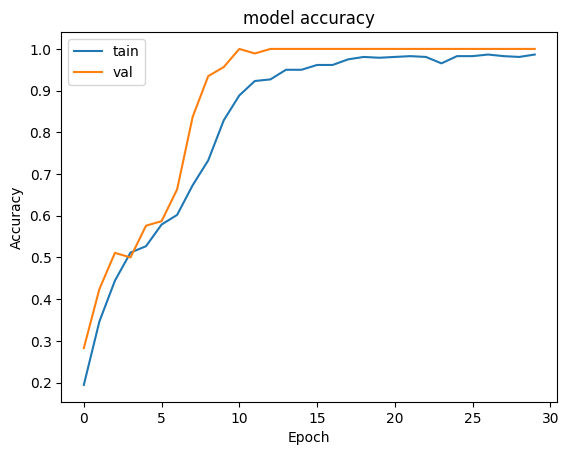

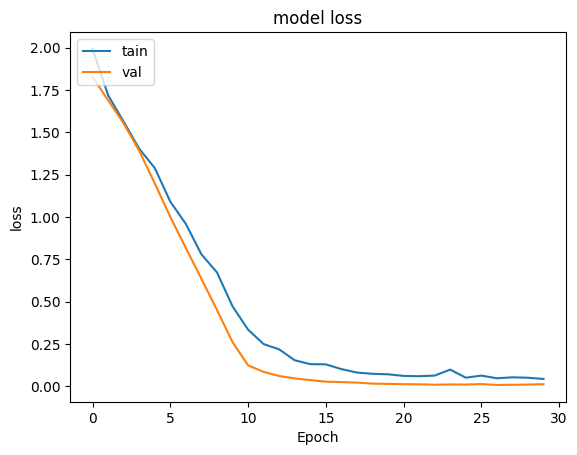

In [52]:
history1=lstm.fit(X_train,Y_train,batch_size=30,validation_split=0.15,epochs=30)

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['tain','val'],loc='upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['tain','val'],loc='upper left')
plt.show()

In [53]:
lstm.save("LSTMmodel.h5")
lst=models.load_model('LSTMmodel.h5')

##Model testing and evaluation

In [54]:
lstm.evaluate(X_test,Y_test)

4/4 [==============================] - 0s 17ms/step - loss: 0.0165 - accuracy: 0.9908


[0.01653706096112728, 0.9908257126808167]

In [61]:
y_prediction1=lstm.predict(X_test)
y_prediction1 = [np.argmax(element)for element in y_prediction1 ]

print(classification_report(Y_test,y_prediction1))
print(confusion_matrix(Y_test , y_prediction1))

roc = roc_auc_score(Y_test, lstm.predict(X_test), multi_class ='ovr')
kappa = cohen_kappa_score(Y_test, lstm.predict(X_test).argmax(axis=1))

print("Roc score", roc)
print("Kappa score", kappa)


4/4 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        16
           4       0.89      1.00      0.94         8
           5       1.00      0.88      0.93         8
           6       1.00      1.00      1.00        23

    accuracy                           0.99       109
   macro avg       0.98      0.98      0.98       109
weighted avg       0.99      0.99      0.99       109

[[19  0  0  0  0  0  0]
 [ 0 17  0  0  0  0  0]
 [ 0  0 18  0  0  0  0]
 [ 0  0  0 16  0  0  0]
 [ 0  0  0  0  8  0  0]
 [ 0  0  0  0  1  7  0]
 [ 0  0  0  0  0  0 23]]
4/4 [==============================] - 0s 13ms/step
Roc score 1.0
Kappa score 0.9890934560736442


#Example: pass a video to the model

In [71]:
s='/content/drive/MyDrive/subject_6/like_04.mp4'
cap=cv2.VideoCapture(s)
i=0
nb=0
listeRL=[]
while cap.isOpened():

  imageId=cap.get(1)
  ret,image=cap.read()
  if ret !=True:
    break

  if imageId != 0:
    if imageId % 4 == 0:
      nb=nb+1
      namefile=str(nb)+'.jpg'
      cv2.imwrite(namefile,image)
      image=imread(namefile)

      if image.ndim==3:
        image = cv2.GaussianBlur(image, (5,5) , 100)
        red , green , blue = image[:,:,0] ,image[:,:,1] , image[:,:,2]


        image_hsv = rgb2hsv(image)
        hue = image_hsv[:,:,0]
        sat = image_hsv[:,:,1]

        image_ycbcr = rgb2ycbcr(image)
        y = image_ycbcr[:,:,0]
        cb = image_ycbcr[:,:,1]
        cr = image_ycbcr[:,:,2]




        mask = (red > 95) & (green > 40) & (blue > 20) & (red > green) & (red > blue) & (np.abs(red - green) > 15) & (cr > 135) & (cb > 85) & (y > 80) & (cr <= (1.5862*cb)+20) & (cr >= (0.3448*cb)+76.2069) & (cr >= (-4.5652*cb)+234.5652) & (cr <= (-1.15 * cb)+301.75) & (cr <= (-2.2857*cb)+432.85)
        mask = mask.astype(np.uint8)
        mask[mask == 1] = 255
        np.sum(mask == 255)


        kernel = np.ones((5,5), np.uint8)
        mask1 = cv2.erode(mask , kernel , iterations=2)

        kernel = np.ones((5,5), np.uint8)
        image = cv2.dilate(mask1 , kernel , iterations=4)
        #image=cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        image=resize(image,(128,128))

        listeRL.append(image)

listeRL.pop()


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Mettre les frames en block

In [72]:
listeR=[]
listeR=np.array(listeRL).reshape(-1,128,128,1)

listeRR=[]
listeRR=listeR/255

listeR=[]
listeR=modelfeatures.predict(listeRR)

listo=[]
lis=[]
i=0
for ph in listeR:
  i=i+1
  lis.append(ph)
  if i==6:
    listo.append(lis)
    i=0
    lis=[]

listeR=np.array(listo).reshape(-1,6,150)
print(listeR.shape)

1/1 [==============================] - 0s 372ms/step
(1, 6, 150)


In [73]:
y_pred=lstm.predict(listeR)
print("probabilities list", y_pred)

ycla = [np.argmax(element)for element in y_pred ]
i=0
for i in ycla :
  for j in label2int:
    if label2int[j] == i:
      print(j)

1/1 [==============================] - 0s 60ms/step
probabilities list [[2.0159056e-04 7.9890341e-01 1.9421242e-01 5.7913666e-04 4.2693717e-03
  1.6389845e-03 1.9503101e-04]]
like
